<div class="alert alert-info" align = "center"> <h1> LENDING CLUB - Data Preparation & Processing </h1> </div>

---
---

# <font color=red> Table of contents </font>
<a id="content_table"></a>

<b>Part 1. Introduction </b><br>

<b>Part 2. Setup</b><br>
2.1) [Configuration](#descriptive_statistics)<br>
2.2) [Librabries](#descriptive_statistics)<br>
2.3) [Utility Functions](#descriptive_statistics)<br>

<b>Part 3. Data Cleansing</b><br>
3.1) [Data Collection](#descriptive_statistics)<br>
3.2) [Train-Test Split](#descriptive_statistics)<br>

<b>Part 4. Data Processing</b><br>

<b>Part 5. Create Pipelines</b><br>
5.1) [Pipeline1](#cleansing_data)<br>
5.2) [Pipeline2](#missing_data)<br>


### References:
1) <a src="https://www.kaggle.com/vigilanf/loan-metrics-by-state"> Loan Metrics By State </a> by Frank Vigilante<br>
2) Hands on Machine Learning by Aurélien Géron <br>

---
---

# <font color=red> 1. Introduction

Afer performing Exploratory Data Analysis step, we now have knowledge and strategies to prepare the data for Machine Learning algorithms. Instead of just doing this manually, you should write functions to do that, for several good reasons:

+ This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset)
+ You will gradually build a libray of transformation functions that you can reuse in future projects
+ You can use these functions in you live system to transform the new data before feeding it to your algorithms
+ This will make it possible for you to easily try various transformations and see which combination of transformations works best
    
For this dataset, the following tasks will be applied to transform data:

1. Clean data
 
1. Remove vars: grade, title, installment
2. Numeric data:
    + inq_last_6mths: combine value 6, 7 & 8 to 6
    + pub_rec_bin: convert to binary var
    + delinq_2yrs_bin: convert to binary vvar
4. Categorical data:
    + Convert ordinal data to numeric data: term, emp_length
    + Encode cat vars - calculate class ratio: ['sub_grade', 'purpose', 'zip_code']
    + Encode cat vars - create dummy vars []
5. temporal vars:
    + convert obj var to date time var: issue_d, earliest_cr_line
    + num_of_year
    + num_of_day
6. Handling missing data:
    + numeric data
    + categorical var
7. Scaling num var
8. Handling outliers
9. Processing Text var

---
---

# <font color=red> 2. Setup

### <font color=blue> 2.1. Import library

In [44]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
from pathlib import Path
import os

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Dataframe manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, Normalizer, scale

# Modelling Helpers:
from sklearn.feature_selection import RFECV
from sklearn import model_selection
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score,ShuffleSplit,cross_validate

# math & statsmodels
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels as statm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import math
from math import sqrt

# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation metrics for Classification
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score,classification_report,roc_auc_score,roc_curve,precision_recall_curve,average_precision_score

# Others
import joblib

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

Setup complete...


### <font color=blue> 2.2. Configuration

In [12]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# sns.set(style = 'whitegrid',context = 'notebook')
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### <font color=blue> 2.3. Define utility function

In [13]:
def calculate_class_ratio(data, var):
    class_0 = data[data['Class']==0].groupby(var).count()['Class']
    class_1 = data[data['Class']==1].groupby(var).count()['Class']
    class_ratio = class_1/class_0    
    
    return class_ratio


---
---
# <font color=red> 3. Data Preprocessing

### <font color=blue> 3.1. Data Collection

There are many LendingClub data sets on Kaggle. We will be using a subset of the Lending Club datatset obtained from Kaggle: https://www.kaggle.com/wordsforthewise/lending-club

In [14]:
data_file = "loan_data_2007_2014.csv"
df = pd.read_csv(data_file)
print(df.shape)
df.head()

(466285, 75)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color=blue>3.2. Split data to train set and test set
    
1. In general, the model is trained and tested in the following way: The data is split into two parts. The first part is training set, it will be used for training model to learn data and inference parameters by minimizing error between model output and observed output, this is called "training error". The second part is used fro testing the "generalization" ability of the model, i.e., its ability to give the correct answer to a new case, this is called "generation error" or "test error"
    
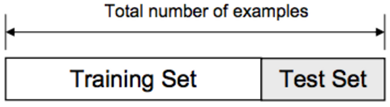
    
2. We train the model on the training set, and test the accuracy of the model on the test set

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

train_df = train_set.copy()
test_df = test_set.copy()

+ The whole dataset is split with 80% for training and 20% for testing. This left 182.436 samples for train set and 45.610 for test set.
+ Stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

In [16]:
train_df.shape, test_df.shape

((373028, 75), (93257, 75))

In [17]:
train_df.head(5)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,A5,Supervisor inventory management,3 years,MORTGAGE,77000.0,Source Verified,Mar-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 03/12/14 > I have 5 credit...,debt_consolidation,Debt consolidation,295xx,SC,21.91,0.0,Dec-86,1.0,NaN,NaN,20.0,0.0,30489,53.5,32.0,f,10098.30,10098.30,16765.76000,16765.76,13901.70,2864.06,0.00,0.00,0.000,Jan-16,762.08,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,348253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57000.0,NaN,NaN,NaN
1,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,C1,mizuho corporate bank,6 years,MORTGAGE,112000.0,Not Verified,Aug-12,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 07/23/12 > I was looking f...,debt_consolidation,Credit card consolidation,070xx,NJ,7.49,1.0,Dec-97,2.0,18.0,NaN,15.0,0.0,15836,53.1,38.0,f,0.00,0.00,12357.02066,12357.02,10000.00,2357.02,0.00,0.00,0.000,Aug-15,355.11,NaN,Jul-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,A5,Internal Medicine of Griffin,10+ years,MORTGAGE,84000.0,Verified,Jun-13,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Lend Club,302xx,GA,14.83,0.0,Jul-91,1.0,46.0,NaN,9.0,0.0,29813,89.5,20.0,f,3183.62,3183.62,20090.40000,20090.40,17241.38,2849.02,0.00,0.00,0.000,Jan-16,648.56,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,385187.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33300.0,NaN,NaN,NaN
3,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,D1,Administrative Assistant,7 years,RENT,43000.0,Source Verified,Apr-14,Late (31-120 days),n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,015xx,MA,13.68,1.0,Oct-98,3.0,6.0,NaN,9.0,0.0,7523,60.2,13.0,f,9459.50,9459.50,11615.36000,11615.36,7740.50,3844.37,30.49,0.00,0.000,Jan-16,640.22,Feb-16,Jan-16,0.0,50.0,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,22958.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12500.0,NaN,NaN,NaN
4,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,C2,Bank of A,5 years,MORTGAGE,94000.0,Verified,Jul-09,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Unexpectd California tuition hike - Need help ...,educational,Student Loan,913xx,CA,22.54,0.0,Jul-98,1.0,NaN,NaN,14.0,0.0,65621,81.5,30.0,f,0.00,0.00,5422.21000,4808.80,3566.58,1231.84,0.00,623.79,28.256,Dec-10,282.40,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color=blue>3.3. Define functions

#### Define data files to store temporal calculation

In [18]:
credit_risk_class_ratio = 'credit_risk_class_ratio.npy'
credit_risk_median_imputer = 'credit_risk_median_imputer.npy'
credit_risk_scaler = 'credit_risk_scaler.pkl'
credit_risk_dummy_vars = 'credit_risk_dummy_vars.npy'

#### Define class for data pipeline 

In [54]:
class CreditRisk:
    """
    This class enables data processing for Lending Club 
        
    """
    ##############################################################################################
    # Define parameters
    ##############################################################################################
    # original vars: features of interest
    SELECTED_VARS = ['installment','loan_amnt','term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 
                     'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 
                     'issue_d', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',  
                     'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 
                     'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type']
    
    # target 
    RAW_TARGET = 'loan_status'
    TARGET_VALUE = ['Fully Paid', 'Charged Off', 'Default']
    TARGET = 'Class'
    
    # all features
    ALL_VARS = SELECTED_VARS + [RAW_TARGET]
    
    NUMERICAL_VARS = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 
                      'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']
    CATEGORICAL_VARS = ['home_ownership', 'verification_status', 'initial_list_status']
    TEMPORAL_VARS = ['issue_d', 'earliest_cr_line']
    RATIO_VARS = ['sub_grade', 'purpose', 'zip_code']
    
    # rename columns
    FEATURE_MAP = {'loan_status': 'Class',}
    
    # mapping value
    TARGET_VALUE_MAPPING = {'Fully Paid':0, 'Charged Off':1, 'Default':1}
    TERM_MAPPING = {'36 months': 36, '60 months': 60}
    EMP_LEN_MAPPING = {'10+ years':10, 
                       '9 years':9, 
                       '8 years':8,
                       '7 years':7,
                       '6 years':6,
                       '5 years':5,
                       '4 years':4,
                       '3 years':3,
                       '2 years':2,
                       '1 year':1,
                       '< 1 year':0.5}
    
    upper_threshold = {'annual_inc': 250697,
                    'revol_bal': 71467, 
                    'revol_util': 223, 
                    'zip_code_ratio':0.543, 
                    'total_acc': 96, 
                    'open_acc': 37
                    }
    lower_threshold = {'annual_inc': -119558,
                    'revol_bal': -46514, 
                    'revol_util': -111, 
                    'zip_code_ratio':-0.079, 
                    'total_acc': -48,
                    'open_acc': -17
                    }
                 

    ##############################################################################################
    # Initialize class oject
    ##############################################################################################
    def __init__(self):
 
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.processed_X_train = None
        self.processed_X_test = None
        

    ##############################################################################################
    # Data Processing
    ##############################################################################################   
    def clean_data(self, df):
        
        data = df.copy()
        
        # Select final features
        data = data[self.ALL_VARS]
        
        # Select valid rows: target value is in ['Fully Paid', 'Charged Off', 'Default']
        data = data[data[self.RAW_TARGET].isin(self.TARGET_VALUE)]
        
        # Rename columns
        data.rename(columns=self.FEATURE_MAP, inplace=True)
        
        # transform target values
        data = self.transform_target_value(data)
        
        # data type conversion
        '''
        for key in self.DATA_TYPE:
            data[key] =  data[key].astype(self.DATA_TYPE[key])
        '''
        
        # Remove duplicated data
        data = data.drop_duplicates(keep='last')
        
        # Reset index
        data = data.reset_index(drop=True)
        
        return data
     
    
    def transform_target_value(self, df):
        data = df.copy()
        data[self.TARGET] = data[self.TARGET].map(self.TARGET_VALUE_MAPPING)
        return data
        
                
    def set_max_threshold(self, df, var, threshold):
        data = df.copy()
        data[var] = data[[var]].applymap(lambda x: x if x < threshold else threshold)
        return data
    
    
    def transform_contvar_binvar(self, df, var, threshold):
        data = df.copy()
        data[var] = data[[var]].applymap(lambda x:0 if x<= threshold else 1 )
        return data
   
    
    def transform_mapping_value(self, df, var, mapping_value):
        
        data = df.copy()
        # to remove  white space at both ends
        data[var] = data[var].str.strip()
        data[var] = data[var].map(mapping_value)
        return data
       
    
    def calculate_class_ratio(self, df, var_list, train_flag=0):
        
        data = df.copy()
        # Training
        if(train_flag == 1):
            class_ratio_dict = {}
            for var in var_list:
                class_0 = data[data[self.TARGET] == 0].groupby(var).count()[self.TARGET]
                class_1 = data[data[self.TARGET] == 1].groupby(var).count()[self.TARGET]
                class_ratio = class_1/class_0
                class_ratio_dict[var] = class_ratio
            np.save(credit_risk_class_ratio, class_ratio_dict)
        else:
            class_ratio_dict = np.load(credit_risk_class_ratio, allow_pickle=True).item()
            
        for var in var_list:
            class_ratio = class_ratio_dict[var]
            data[var + '_ratio'] = data[var].map(class_ratio)
            
        return data
                

    def transform_temporal_vars(self, df):

        data = df.copy()
        
        # convert to datetime data
        data['issue_d_date'] = pd.to_datetime(data['issue_d'], format = '%b-%y')
        data['earliest_cr_line_date'] = pd.to_datetime(data['earliest_cr_line'], format = '%b-%y')
        
        data['issue_d_year'] = data['issue_d_date'].dt.year
        data['earliest_cr_year'] = data['earliest_cr_line_date'].dt.year
        data['num_of_year'] = data['issue_d_year'] - data['earliest_cr_year']

        return data
       

    def impute_na_median(self, df, var_list, train_flag=0):
        
        data = df.copy()
        
        if(train_flag == 1):
            median_var_dict = {}
            for var in var_list:
                median_val = data[var].median()
                median_var_dict[var] = median_val
            # save result
            np.save(credit_risk_median_imputer, median_var_dict)
        else:
            median_var_dict = np.load(credit_risk_median_imputer, allow_pickle=True).item()
            
        for var in var_list:
            median_var = median_var_dict[var]
            data[var].fillna(median_var, inplace=True)
        
        return data
            
    
    def set_boundary(self, df, var, upper_boundary, lower_boundary):
        data = df.copy()             
        data.loc[data[var] <= lower_boundary,var] = lower_boundary
        data.loc[data[var] >= upper_boundary,var] = upper_boundary
        return data

    
    def scaling_data(self, df, var_list, train_flag=0):
        
        data = df.copy()
        # persist the model for future use
        if(train_flag ==1 ):
            # fit scaler
            scaler = MinMaxScaler()
            scaler.fit(data[var_list])
            joblib.dump(scaler, credit_risk_scaler)
        scaler = joblib.load(credit_risk_scaler)      
        data = pd.DataFrame(scaler.transform(data[var_list]), columns=var_list)
        
        return data

    
    def create_dummy_vars(self, df, var_list, train_flag=0):
        
        data = df.copy()
        data_categorical = pd.DataFrame()
        for var in var_list:
            data_dummies = pd.get_dummies(data[var], prefix=var, prefix_sep='_', drop_first=True)
            data_categorical = pd.concat([data_categorical, data_dummies], axis=1)
            
        if(train_flag ==1 ):
            train_dummy = list(data_categorical.columns)
            pd.Series(train_dummy).to_csv(credit_risk_dummy_vars, index=False)
        else:
            test_dummy = list(data_categorical.columns)
            
        train_dummy = pd.read_csv(credit_risk_dummy_vars)
        train_dummy.columns = ['Name']
        train_dummy = list(train_dummy.Name.values)
        
        for col in train_dummy:
            if col not in data_categorical:
                data_categorical[col] = 0
                
        return data_categorical
    
    
    def data_processing_pipeline1(self, df, train_flag=0):
        
        TRAIN_NUM_VARS = ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
                          'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'emp_length',
                          'num_of_year', 'sub_grade_ratio', 'purpose_ratio', 'zip_code_ratio']

        data = self.clean_data(df)
        # mapping term
        data = self.transform_mapping_value(data, 'term', self.TERM_MAPPING)
        # mapping emp_length
        data = self.transform_mapping_value(data, 'emp_length', self.EMP_LEN_MAPPING)
        # transform categorical var to num var using class ratio
        data = self.calculate_class_ratio(data, self.RATIO_VARS, train_flag)
        # data engineering for temporal vars
        data = self.transform_temporal_vars(data)
        # impute missing values
        data = self.impute_na_median(data, TRAIN_NUM_VARS,train_flag)
        # scaling numeric vars
        data_scaled = self.scaling_data(data, TRAIN_NUM_VARS, train_flag)
        # create dummy vars for categorical vars
        data_categorical = self.create_dummy_vars(data, self.CATEGORICAL_VARS, train_flag)
        # combine num vars and cat vars to final dataset
        data = pd.concat([data_scaled,data_categorical,data[self.TARGET]], axis=1)
        # define TRAIN_VARS and TRAIN_NUM_VARS
        self.TRAIN_VARS = data.drop([self.TARGET],axis=1).columns
        self.TRAIN_NUM_VARS = data_scaled.columns
        self.TRAIN_DUM_VARS = data_categorical.columns
        
        return data
      


    def data_processing_pipeline2(self, df, train_flag=0):
        
        TRAIN_NUM_VARS = ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
                          'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'emp_length',
                          'num_of_year', 'sub_grade_ratio', 'purpose_ratio', 'zip_code_ratio']

        data = self.clean_data(df)
        # combine several values in one group
        data = self.transform_contvar_binvar(data, 'delinq_2yrs', 2)
        data = self.set_max_threshold(data, 'inq_last_6mths', 6)
        data = self.transform_contvar_binvar(data, 'pub_rec', 3)
        # mapping term
        data = self.transform_mapping_value(data, 'term', self.TERM_MAPPING)
        # mapping emp_length
        data = self.transform_mapping_value(data, 'emp_length', self.EMP_LEN_MAPPING)
        # transform categorical var to num var using class ratio
        data = self.calculate_class_ratio(data, self.RATIO_VARS, train_flag)
        # data engineering for temporal vars
        data = self.transform_temporal_vars(data)
        # set limit for outliers
        for var in self.upper_threshold.keys():
            data = self.set_boundary(data, var, self.upper_threshold[var], self.lower_threshold[var])
        # impute missing values
        data = self.impute_na_median(data, TRAIN_NUM_VARS,train_flag)
        # scaling numeric vars
        data_scaled = self.scaling_data(data, TRAIN_NUM_VARS, train_flag)
        # create dummy vars for categorical vars
        data_categorical = self.create_dummy_vars(data, self.CATEGORICAL_VARS, train_flag)
        # combine num vars and cat vars to final dataset
        data = pd.concat([data_scaled,data_categorical,data[self.TARGET]], axis=1)
        # define TRAIN_VARS and TRAIN_NUM_VARS
        self.TRAIN_VARS = data.drop([self.TARGET],axis=1).columns
        self.TRAIN_NUM_VARS = data_scaled.columns
        self.TRAIN_DUM_VARS = data_categorical.columns
        
        return data

---
---
# <font color=red> 5. Create Pipelines

### <font color=blue> 5.1. Pipeline 1

In [45]:
credit_risk = CreditRisk()
processed_train_df1 = credit_risk.data_processing_pipeline1(train_df, train_flag=1)
print(processed_train_df1.shape)
processed_train_df1.head()

(182498, 26)


,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,emp_length,num_of_year,sub_grade_ratio,purpose_ratio,zip_code_ratio,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,Class
0,0.275362,0.0,0.431686,0.015269,0.187344,0.034483,0.250,0.197368,0.0,0.009066,0.059509,0.243243,0.578947,0.714286,0.208883,0.371387,0.070045,1,0,0,0,0,0,0,0,0
1,0.228986,0.0,0.359496,0.012747,0.563782,0.000000,0.125,0.184211,0.0,0.037568,0.091337,0.189189,0.473684,0.676190,0.229165,0.186905,0.066508,1,0,0,0,0,0,1,0,1
2,0.130435,1.0,0.251938,0.010786,0.120810,0.000000,0.000,0.065789,0.0,0.000852,0.047630,0.027027,0.157895,0.619048,0.135145,0.487562,0.059989,0,0,0,0,1,0,0,0,0
3,0.681159,1.0,0.721415,0.007901,0.580540,0.000000,0.125,0.171053,0.0,0.007502,0.095372,0.128378,0.894737,0.685714,0.471674,0.371387,0.070218,1,0,0,0,0,0,1,0,0
4,0.594203,1.0,0.479167,0.017790,0.322661,0.000000,0.125,0.263158,0.0,0.011922,0.059845,0.229730,1.000000,0.714286,0.229165,0.186941,0.051772,1,0,0,0,0,0,1,0,0


In [11]:
processed_test_df1 = credit_risk.data_processing_pipeline1(test_df, train_flag=0)
print(processed_test_df1.shape)
processed_test_df1.head()

(45548, 26)


,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,emp_length,num_of_year,sub_grade_ratio,purpose_ratio,zip_code_ratio,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,home_ownership_MORTGAGE,Class
0,0.927536,1.0,0.463663,0.008685,0.233117,0.000000,0.000,0.092105,0.0,0.000692,0.004819,0.121622,0.000000,0.685714,0.332675,0.186941,0.060344,0,0,0,0,0,1,0,0,0
1,0.855072,0.0,0.447190,0.024094,0.333667,0.000000,0.000,0.118421,0.0,0.001091,0.025104,0.243243,0.052632,0.666667,0.229165,0.371387,0.059222,0,0,0,0,0,1,0,0,0
2,0.420290,0.0,0.168605,0.011487,0.207604,0.000000,0.000,0.092105,0.0,0.003379,0.075983,0.121622,1.000000,0.828571,0.073167,0.371387,0.074163,0,0,0,0,0,1,0,0,0
3,0.275362,0.0,0.522287,0.005463,0.691846,0.068966,0.125,0.118421,0.0,0.008680,0.080578,0.229730,0.000000,0.695238,0.297200,0.186941,0.152732,0,0,0,0,1,0,0,0,0
4,0.333333,1.0,0.510174,0.012607,0.378689,0.000000,0.000,0.092105,0.0,0.005873,0.054018,0.310811,1.000000,0.761905,0.451353,0.371387,0.059203,0,0,0,0,0,0,0,0,0


In [12]:
processed_train_df1.to_csv('../data/processed/loan_data_pipeline1_train.csv', index=False)
processed_test_df1.to_csv('../data/processed/loan_data_pipeline1_test.csv', index=False)

In [13]:
credit_risk.TRAIN_DUM_VARS

Index(['home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'initial_list_status_w', 'home_ownership_MORTGAGE'], dtype='object')

### <font color=blue> 5.2. Pipeline 2

In [55]:
credit_risk = CreditRisk()
processed_train_df2 = credit_risk.data_processing_pipeline2(train_df, train_flag=1)
print(processed_train_df2.shape)
processed_train_df2.head()

(182498, 26)


,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,emp_length,num_of_year,sub_grade_ratio,purpose_ratio,zip_code_ratio,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,Class
0,0.275362,0.0,0.431686,0.440054,0.187344,0.0,0.333333,0.197368,0.0,0.221585,0.238117,0.243243,0.578947,0.714286,0.208883,0.371387,0.405719,1,0,0,0,0,0,0,0,0
1,0.228986,0.0,0.359496,0.367384,0.563782,0.0,0.166667,0.184211,0.0,0.918200,0.365471,0.189189,0.473684,0.676190,0.229165,0.186905,0.385233,1,0,0,0,0,0,1,0,1
2,0.130435,1.0,0.251938,0.310864,0.120810,0.0,0.000000,0.065789,0.0,0.020821,0.190583,0.027027,0.157895,0.619048,0.135145,0.487562,0.347472,0,0,0,0,1,0,0,0,0
3,0.681159,1.0,0.721415,0.227698,0.580540,0.0,0.166667,0.171053,0.0,0.183357,0.381614,0.128378,0.894737,0.685714,0.471674,0.371387,0.406724,1,0,0,0,0,0,1,0,0
4,0.594203,1.0,0.479167,0.512723,0.322661,0.0,0.166667,0.263158,0.0,0.291393,0.239462,0.229730,1.000000,0.714286,0.229165,0.186941,0.299877,1,0,0,0,0,0,1,0,0


In [56]:
processed_test_df2 = credit_risk.data_processing_pipeline2(test_df, train_flag=0)
print(processed_test_df2.shape)
processed_test_df2.head()

(45548, 26)


,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,emp_length,num_of_year,sub_grade_ratio,purpose_ratio,zip_code_ratio,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,home_ownership_MORTGAGE,Class
0,0.927536,1.0,0.463663,0.250306,0.233117,0.0,0.000000,0.092105,0.0,0.016903,0.019283,0.121622,0.000000,0.685714,0.332675,0.186941,0.349532,0,0,0,0,0,1,0,0,0
1,0.855072,0.0,0.447190,0.694397,0.333667,0.0,0.000000,0.118421,0.0,0.026670,0.100448,0.243243,0.052632,0.666667,0.229165,0.371387,0.343034,0,0,0,0,0,1,0,0,0
2,0.420290,0.0,0.168605,0.331050,0.207604,0.0,0.000000,0.092105,0.0,0.082584,0.304036,0.121622,1.000000,0.828571,0.073167,0.371387,0.429575,0,0,0,0,0,1,0,0,0
3,0.275362,0.0,0.522287,0.157450,0.691846,0.0,0.166667,0.118421,0.0,0.212140,0.322422,0.229730,0.000000,0.695238,0.297200,0.186941,0.884671,0,0,0,0,1,0,0,0,0
4,0.333333,1.0,0.510174,0.363347,0.378689,0.0,0.000000,0.092105,0.0,0.143535,0.216143,0.310811,1.000000,0.761905,0.451353,0.371387,0.342920,0,0,0,0,0,0,0,0,0


In [57]:
processed_train_df2.to_csv('../data/processed/loan_data_pipeline2_train.csv', index=False)
processed_test_df2.to_csv('../data/processed/loan_data_pipeline2_test.csv', index=False)